In [1]:
import shap
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from dataclasses import dataclass
from mbeml.featurization import data_prep, latex_feature_names
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.shap_utils import sum_ligand_features, custom_beeswarm, draw_colorbar

2024-09-12 22:35:20.520325: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 22:35:20.521802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 22:35:20.548870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 22:35:20.549767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 22:35:21.044951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
@dataclass
class ModelFeatureImportance:
    display_name: str
    model_name: str
    shap_values = shap.Explanation(np.empty(0))
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False

In [4]:
feature_importances = [
    ModelFeatureImportance(
        display_name="SSE",
        model_name="nn_two_body",
        features=LigandFeatures.LIGAND_RACS,
        is_nn=True,
    ),
    ModelFeatureImportance(
        display_name="gap$_\\mathrm{LS}$",
        model_name="nn_two_body",
        features=LigandFeatures.LIGAND_RACS,
        target=TargetProperty.ORBITALS,
        is_nn=True,
    ),
    ModelFeatureImportance(
        display_name="gap$_\\mathrm{HS}$",
        model_name="nn_two_body",
        features=LigandFeatures.LIGAND_RACS,
        target=TargetProperty.ORBITALS,
        is_nn=True,
    ),
]

In [5]:
class WrapperSSE(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super().__init__(self, **kwargs)
        self.model = model

    def call(self, X):
        input_dict = {"core": X[:, :7], "ligands": tf.reshape(X[:, 7:], (-1, 6, 32))}
        return self.model(input_dict)[0][:, 0]


class WrapperGapLS(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super().__init__(self, **kwargs)
        self.model = model

    def call(self, X):
        input_dict = {"core": X[:, :7], "ligands": tf.reshape(X[:, 7:], (-1, 6, 32))}
        orbs = self.model(input_dict)[0]
        return orbs[:, 0] - orbs[:, 2]


class WrapperGapHS(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super().__init__(self, **kwargs)
        self.model = model

    def call(self, X):
        input_dict = {"core": X[:, :7], "ligands": tf.reshape(X[:, 7:], (-1, 6, 32))}
        orbs = self.model(input_dict)[0]
        return orbs[:, 1] - orbs[:, 3]

In [6]:
try:
    with open("shap_values_nn_two_body.pickle", "rb") as fin:
        saved_shap_values = pickle.load(fin)
    for shap_val in feature_importances:
        shap_val.shap_values = saved_shap_values[
            (shap_val.model_name, shap_val.display_name)
        ]
    print("Successfully loaded pickled SHAP values")
except FileNotFoundError:
    # This is how the feature importance was originally evaluated:

    model_dir = Path("../../models/")
    data_dir = Path("../../data/")
    train_data = pd.read_csv(data_dir / "training_data.csv")
    test_data = pd.read_csv(data_dir / "ligand_test_data.csv")

    saved_shap_values = {}
    # Evaluate feature importance
    for shap_val in feature_importances:
        X_train, _ = data_prep(
            train_data, shap_val.features, shap_val.target, is_nn=False
        )
        X_test, _ = data_prep(
            test_data, shap_val.features, shap_val.target, is_nn=False
        )
        X_dict, _ = data_prep(test_data, shap_val.features, shap_val.target, is_nn=True)
        X_summary = shap.kmeans(X_train, 25)

        if shap_val.is_nn:
            model = tf.keras.models.load_model(
                model_dir / shap_val.target.name.lower() / shap_val.model_name
            )

            if "SSE" in shap_val.display_name:
                wrapped_model = WrapperSSE(model)
                np.testing.assert_allclose(
                    model(X_dict)[0][:, 0], wrapped_model(X_test)
                )
            elif "LS" in shap_val.display_name:
                wrapped_model = WrapperGapLS(model)
                pred = model(X_dict)[0]
                np.testing.assert_allclose(
                    pred[:, 0] - pred[:, 2], wrapped_model(X_test)
                )
            elif "HS" in shap_val.display_name:
                wrapped_model = WrapperGapHS(model)
                pred = model(X_dict)[0]
                np.testing.assert_allclose(
                    pred[:, 1] - pred[:, 3], wrapped_model(X_test)
                )
            else:
                raise NotImplementedError()

            def predict_fun(x):
                return wrapped_model.predict(x, verbose=0)
        else:
            raise NotImplementedError()

        # Since seed is not properly passed to KernelExplainer
        np.random.seed(seed=0)
        explainer = shap.KernelExplainer(
            model=predict_fun,
            data=X_summary,
            feature_names=latex_feature_names(shap_val.features),
            seed=0,
        )
        shap_val.shap_values = explainer(X_test)
        saved_shap_values[(shap_val.model_name, shap_val.display_name)] = (
            shap_val.shap_values
        )
    with open("shap_values_nn_two_body.pickle", "wb") as fout:
        saved_shap_values = pickle.dump(saved_shap_values, fout)


Successfully loaded pickled SHAP values


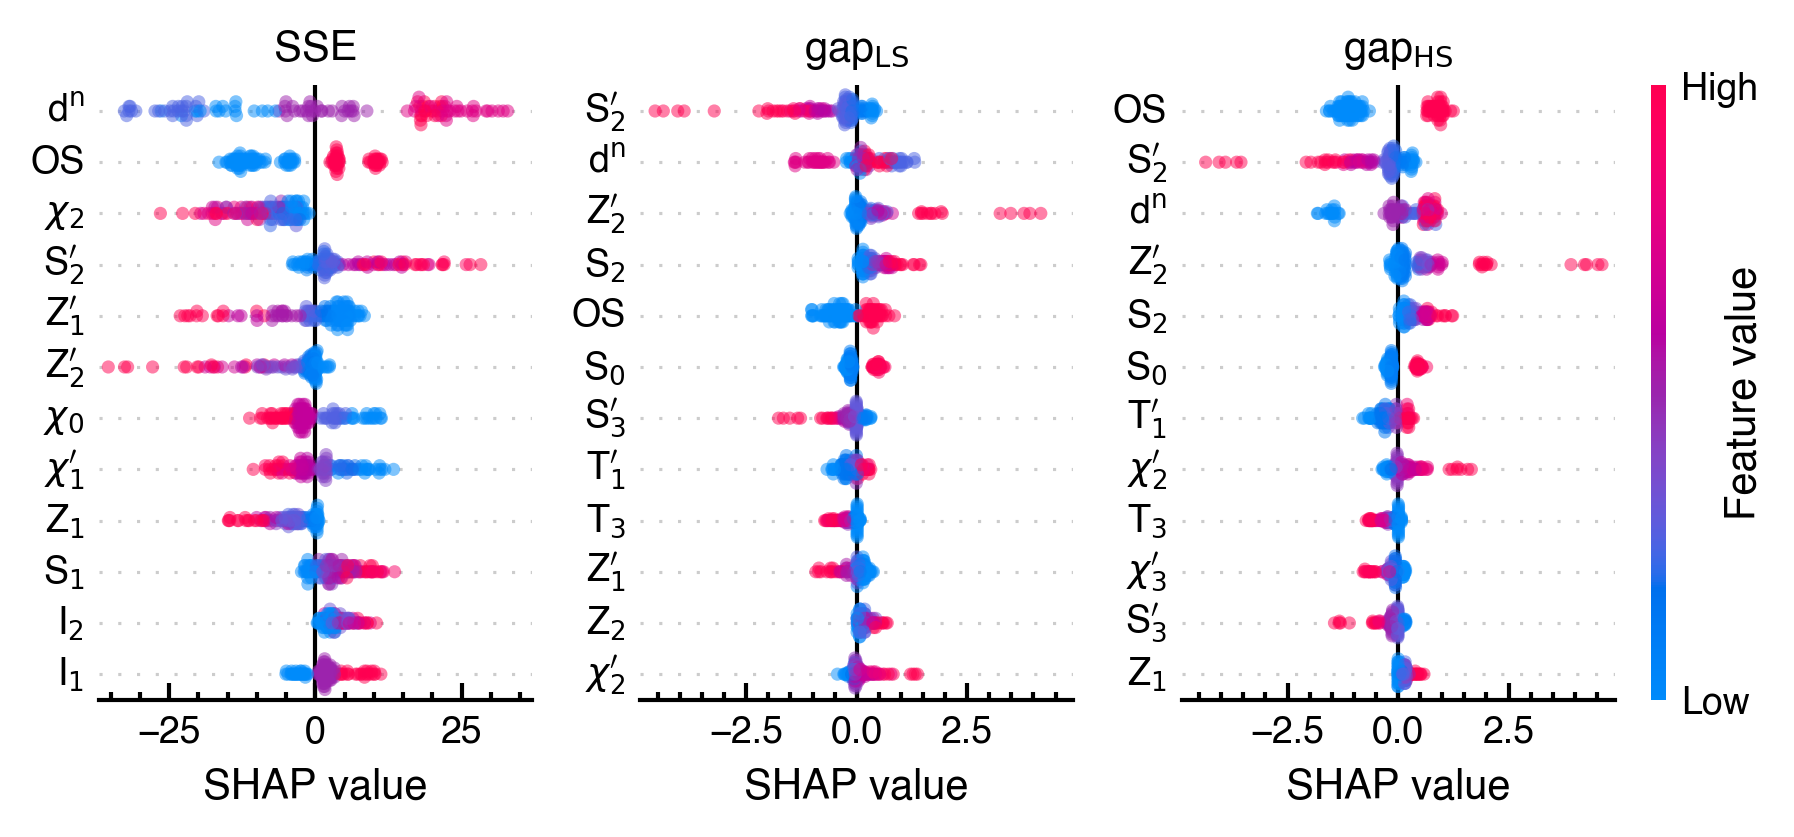

In [7]:
fig = plt.figure(figsize=(5.91, 0.45 * 5.91))
axes = fig.subplots(
    ncols=3,
    sharex=False,
    sharey=False,
    gridspec_kw=dict(
        hspace=0.0,
        wspace=0.25,
        left=0.05,
        right=1.08,
        top=0.91,
        bottom=0.14,
    ),
)

for feat_imp, ax in zip(feature_importances, axes):
    summed_shap_values = sum_ligand_features(feat_imp.shap_values)
    assert summed_shap_values.shape[1] == 32 + 2

    np.random.seed(seed=0)
    custom_beeswarm(
        summed_shap_values,
        ax=ax,
        max_display=12,
        alpha=0.5,
        order=summed_shap_values.abs.mean(0),
        s=10,
        group_remaining_features=False,
    )
    ax.set_title(feat_imp.display_name)
    ax.set_xlabel("SHAP value")
    if "SSE" in feat_imp.display_name:
        ax.set_xlim(-37, 37)
        ax.set_xticks(np.arange(-7, 8) * 5, minor=True)
    else:
        ax.set_xlim(-4.9, 4.9)
        ax.set_xticks(np.arange(-9, 10) * 0.5, minor=True)
    ax.set_ylim(-0.5, 11.5)

draw_colorbar(axes)

fig.savefig("plots/feature_importance_nn_two_body.pdf")